<a href="https://colab.research.google.com/github/Kussil/Financial_Sentiment_LLM/blob/main/04_Stock_Modeling/Aggregated_Stock_Data/Gemini_Prompt2/Stock_Modeling_Prompt2_Gemini_RF_Tuning_PQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Modeling using Gemini Sentiments

In [1]:
#install dependencies
!pip install -q ipympl

In [2]:
# import libraries
import os
from google.colab import userdata
from google.colab import output
import pandas as pd
import yfinance as yf
import textwrap
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
output.enable_custom_widget_manager()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
#Delete repo clone if needed
!rm -rf /content/CVX_Rice_project/

In [4]:
# Import github token with google secrets thingy and clone git repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

fatal: destination path 'Financial_Sentiment_LLM' already exists and is not an empty directory.


In [5]:
# Read in outputs from Gemini Sentiment Analysis
gemini_prompt2_sentiment = pd.read_csv('/content/Financial_Sentiment_LLM/03_Sentiment_Analysis/Gemini/Prompt2/Prompt2_Sentiment_Analysis_Results.csv')
gemini_prompt2_sentiment = gemini_prompt2_sentiment.fillna('')
gemini_prompt2_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves / Exploration / Acquisitions / Mergers / Divestments,Environment / Regulatory / Geopolitics,Alternative Energy / Lower Carbon,Oil Price / Natural Gas Price / Gasoline Price
0,Investment Research,IR-1,MRO,5/16/2024,,Positive,Neutral,Positive,Negative,Neutral,Neutral
1,Investment Research,IR-2,EOG,5/14/2024,,Positive,Positive,Positive,Neutral,Positive,Neutral
2,Investment Research,IR-3,EOG,5/11/2024,,Positive,Positive,Positive,Neutral,Neutral,Neutral
3,Investment Research,IR-4,DVN,5/11/2024,,Positive,Positive,Negative,Neutral,Neutral,Neutral
4,Investment Research,IR-5,COP,5/7/2024,,Neutral,Neutral,Positive,Negative,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...
10047,Earnings Call Q&A,EQ-338,XOM,2/2/2021,,Positive,Neutral,Positive,Positive,Positive,Neutral
10048,Earnings Call Q&A,EQ-339,COP,2/2/2021,,Positive,Neutral,Positive,Neutral,Positive,Neutral
10049,Earnings Call Q&A,EQ-340,EOG,5/3/2019,,Positive,Positive,Positive,Neutral,Neutral,Neutral
10050,Earnings Call Q&A,EQ-341,SHEL,5/2/2019,,Positive,Positive,Neutral,Neutral,Neutral,Neutral


In [6]:
# Define a list of date formats
date_formats = [
    '%d/%m/%Y',  # 01/01/2021
    '%m/%d/%Y',  # 5/16/2024
    '%Y-%m-%d',  # 2021-02-28
    '%B %d, %Y',  # March 15, 2021
    '%b-%d-%Y',  # Apr-30-2019
    '%Y.%m.%d',  # 2021.04.10
    '%m-%d-%Y',  # 04-10-2021
    '%d-%b-%y',  # 17-Aug-22
    '%b-%y'  # Sep-19
]

# Function to parse dates with multiple formats
def parse_date(date_str):
    for fmt in date_formats:
        try:
            # Handle special case where only month and year are given
            if fmt == '%b-%y':
                parsed_date = datetime.strptime(date_str, fmt)
                # Default to the first day of the month
                return parsed_date.replace(day=1)
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"Date format not recognized: {date_str}")

# Apply the function to the 'Date' column
gemini_prompt2_sentiment['Date'] = gemini_prompt2_sentiment['Date'].apply(parse_date)

# Format the dates in a specific string format
gemini_prompt2_sentiment['Date'] = gemini_prompt2_sentiment['Date'].dt.strftime('%Y-%m-%d')

# Display the DataFrame
gemini_prompt2_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves / Exploration / Acquisitions / Mergers / Divestments,Environment / Regulatory / Geopolitics,Alternative Energy / Lower Carbon,Oil Price / Natural Gas Price / Gasoline Price
0,Investment Research,IR-1,MRO,2024-05-16,,Positive,Neutral,Positive,Negative,Neutral,Neutral
1,Investment Research,IR-2,EOG,2024-05-14,,Positive,Positive,Positive,Neutral,Positive,Neutral
2,Investment Research,IR-3,EOG,2024-11-05,,Positive,Positive,Positive,Neutral,Neutral,Neutral
3,Investment Research,IR-4,DVN,2024-11-05,,Positive,Positive,Negative,Neutral,Neutral,Neutral
4,Investment Research,IR-5,COP,2024-07-05,,Neutral,Neutral,Positive,Negative,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...
10047,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,Positive,Neutral,Positive,Positive,Positive,Neutral
10048,Earnings Call Q&A,EQ-339,COP,2021-02-02,,Positive,Neutral,Positive,Neutral,Positive,Neutral
10049,Earnings Call Q&A,EQ-340,EOG,2019-03-05,,Positive,Positive,Positive,Neutral,Neutral,Neutral
10050,Earnings Call Q&A,EQ-341,SHEL,2019-02-05,,Positive,Positive,Neutral,Neutral,Neutral,Neutral


In [7]:
# Renaming the columns to simplify sentiment categories
gemini_prompt2_sentiment.rename(columns={
    'Reserves / Exploration / Acquisitions / Mergers / Divestments': 'Reserves/M&A',
    'Environment / Regulatory / Geopolitics': 'Regulatory',
    'Alternative Energy / Lower Carbon': 'Green Energy',
    'Oil Price / Natural Gas Price / Gasoline Price': 'OG Price'
}, inplace=True)

gemini_prompt2_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price
0,Investment Research,IR-1,MRO,2024-05-16,,Positive,Neutral,Positive,Negative,Neutral,Neutral
1,Investment Research,IR-2,EOG,2024-05-14,,Positive,Positive,Positive,Neutral,Positive,Neutral
2,Investment Research,IR-3,EOG,2024-11-05,,Positive,Positive,Positive,Neutral,Neutral,Neutral
3,Investment Research,IR-4,DVN,2024-11-05,,Positive,Positive,Negative,Neutral,Neutral,Neutral
4,Investment Research,IR-5,COP,2024-07-05,,Neutral,Neutral,Positive,Negative,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...
10047,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,Positive,Neutral,Positive,Positive,Positive,Neutral
10048,Earnings Call Q&A,EQ-339,COP,2021-02-02,,Positive,Neutral,Positive,Neutral,Positive,Neutral
10049,Earnings Call Q&A,EQ-340,EOG,2019-03-05,,Positive,Positive,Positive,Neutral,Neutral,Neutral
10050,Earnings Call Q&A,EQ-341,SHEL,2019-02-05,,Positive,Positive,Neutral,Neutral,Neutral,Neutral


In [8]:
# Filter out rows where the 'Source' is 'ProQuest'
gemini_prompt2_sentiment = gemini_prompt2_sentiment[gemini_prompt2_sentiment['Source'] == 'ProQuest']

# Display the filtered DataFrame to verify
print(gemini_prompt2_sentiment)

        Source      Unique_ID Ticker        Date  \
4880  ProQuest  PQ-2703147472    CVX  2022-08-17   
4881  ProQuest  PQ-2702197510    CVX  2022-08-15   
4882  ProQuest  PQ-2697049245    CVX  2022-02-08   
4883  ProQuest  PQ-2696371267    CVX  2022-07-30   
4884  ProQuest  PQ-2695835797    CVX  2022-07-29   
...        ...            ...    ...         ...   
8509  ProQuest  PQ-2238653651    PSX  2019-12-06   
8510  ProQuest  PQ-2239478009    PSX  2019-10-06   
8511  ProQuest  PQ-2238860015    PSX  2019-07-06   
8512  ProQuest  PQ-2233473767    PSX  2019-03-06   
8513  ProQuest  PQ-2232566793    PSX  2019-05-31   

                                                    URL   Finance Production  \
4880  https://www.proquest.com/newspapers/chevron-ge...   Neutral    Neutral   
4881  https://www.proquest.com/newspapers/chevron-sl...  Negative   Negative   
4882  https://www.proquest.com/newspapers/chevron-sl...  Negative    Neutral   
4883  https://www.proquest.com/newspapers/senators-a...

In [9]:
#Create Positive and Negative Ratios for each row

# Columns to consider for calculating ratios
columns_to_check = ['Finance', 'Production', 'Reserves/M&A', 'Regulatory', 'Green Energy', 'OG Price']

# Function to calculate positive and negative ratios
def calculate_ratios(row):
    positive_count = (row[columns_to_check] == 'Positive').sum()
    negative_count = (row[columns_to_check] == 'Negative').sum()
    neutral_count = (row[columns_to_check] == 'Neutral').sum()
    total_count = len(columns_to_check)
    pos_ratio = positive_count / total_count
    neg_ratio = negative_count / total_count
    neu_ratio = neutral_count / total_count
    return pd.Series([pos_ratio, neg_ratio, neu_ratio], index=['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio'])

# Apply the function to each row
gemini_prompt2_sentiment[['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio']] = gemini_prompt2_sentiment.apply(calculate_ratios, axis=1)

# Replace senitment category values with binary equivalents
binary_mapping = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
gemini_prompt2_sentiment[columns_to_check] = gemini_prompt2_sentiment[columns_to_check].replace(binary_mapping)

gemini_prompt2_sentiment

<ipython-input-9-aafc2392149c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gemini_prompt2_sentiment[['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio']] = gemini_prompt2_sentiment.apply(calculate_ratios, axis=1)
<ipython-input-9-aafc2392149c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gemini_prompt2_sentiment[['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio']] = gemini_prompt2_sentiment.apply(calculate_ratios, axis=1)
<ipython-input-9-aafc2392149c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price,Pos_Ratio,Neg_Ratio,Neu_Ratio
4880,ProQuest,PQ-2703147472,CVX,2022-08-17,https://www.proquest.com/newspapers/chevron-ge...,0,0,0,0,0,0,0.000000,0.000000,1.000000
4881,ProQuest,PQ-2702197510,CVX,2022-08-15,https://www.proquest.com/newspapers/chevron-sl...,-1,-1,0,0,1,-1,0.166667,0.500000,0.333333
4882,ProQuest,PQ-2697049245,CVX,2022-02-08,https://www.proquest.com/newspapers/chevron-sl...,-1,0,0,0,0,-1,0.000000,0.333333,0.666667
4883,ProQuest,PQ-2696371267,CVX,2022-07-30,https://www.proquest.com/newspapers/senators-a...,0,0,-1,-1,0,0,0.000000,0.333333,0.666667
4884,ProQuest,PQ-2695835797,CVX,2022-07-29,https://www.proquest.com/newspapers/shell-trie...,1,0,-1,1,1,0,0.500000,0.166667,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8509,ProQuest,PQ-2238653651,PSX,2019-12-06,https://www.proquest.com/newspapers/as-price-g...,0,0,0,0,0,-1,0.000000,0.166667,0.833333
8510,ProQuest,PQ-2239478009,PSX,2019-10-06,https://www.proquest.com/newspapers/phillips-6...,1,0,0,0,0,0,0.166667,0.000000,0.833333
8511,ProQuest,PQ-2238860015,PSX,2019-07-06,https://www.proquest.com/newspapers/autonomous...,1,0,0,1,0,0,0.333333,0.000000,0.666667
8512,ProQuest,PQ-2233473767,PSX,2019-03-06,https://www.proquest.com/newspapers/united-sta...,-1,0,0,0,0,-1,0.000000,0.333333,0.666667


In [10]:
#Identify minimum article date for stock price download
min_date = gemini_prompt2_sentiment['Date'].min()
min_date

'2019-01-06'

In [11]:
ticker_list = gemini_prompt2_sentiment['Ticker'].unique().tolist()
ticker_list

['CVX',
 'XOM',
 'OXY',
 'SHEL',
 'BP',
 'COP',
 'MPC',
 'CXO',
 'EQNR',
 'TTE',
 'PXD',
 'EOG',
 'DVN',
 'HES',
 'PSX']

In [12]:
#Pull YahooFinance stock data to get Returns (ret)
all_data = {}

for ticker in ticker_list:
    try:
        # Get the last date for the current ticker from gemini_prompt1_sentiment
        last_date = gemini_prompt2_sentiment[gemini_prompt2_sentiment['Ticker'] == ticker]['Date'].max()
        if pd.isna(last_date):
            print(f"No data available for {ticker} in gemini_prompt1_sentiment.")
            continue

        # Ensure the date is in the correct format
        last_date = pd.to_datetime(last_date).strftime('%Y-%m-%d')
        print(f"Downloading data for {ticker} from {min_date} to {last_date}")

        # Download stock data
        data = yf.download(ticker, start=min_date, end=last_date)["Adj Close"]

        if data.empty:
            print(f"No data retrieved for {ticker}")
        else:
            all_data[ticker] = data

    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Combine all data into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    ret_df = price_df.pct_change().dropna()
    ret_df.name = "ret"
    ret_df.describe()
else:
    print("No data available.")

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CXO']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No data retrieved for CXO


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PXD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No data retrieved for PXD


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


In [13]:
ret_df.describe()

,CVX,XOM,OXY,SHEL,BP,COP,MPC,EQNR,TTE,EOG,DVN,HES,PSX
count,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000
mean,0.000633,0.000743,0.000845,0.000410,0.000375,0.000905,0.001126,0.000644,0.000138,0.000665,0.001299,0.001326,0.000808
std,0.021511,0.020797,0.037924,0.022241,0.022754,0.027027,0.028102,0.023747,0.016485,0.028001,0.035974,0.030194,0.025563
min,-0.221248,-0.122248,-0.520138,-0.171722,-0.191040,-0.248401,-0.270089,-0.210562,-0.178208,-0.320073,-0.373972,-0.336686,-0.158658
25%,-0.008455,-0.010208,-0.014259,-0.008330,-0.009927,-0.011787,-0.009459,-0.011592,0.000000,-0.009360,-0.016060,-0.014226,-0.010344
50%,0.000733,0.000388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001092,0.000134
75%,0.009503,0.011203,0.014360,0.009544,0.009713,0.013891,0.012543,0.013489,0.000000,0.009588,0.017370,0.015101,0.013321
max,0.227407,0.126868,0.336978,0.196795,0.216053,0.252139,0.206286,0.133043,0.152756,0.165703,0.210721,0.203153,0.221722


In [14]:
# add overall article sentiment
df_sentiment = gemini_prompt2_sentiment

# Function to calculate positive and negative ratios
def calculate_ratios2(row):
    positive_count = (row[columns_to_check] == 1).sum()
    negative_count = (row[columns_to_check] == -1).sum()
    neutral_count = (row[columns_to_check] == 0).sum()
    total_count = len(columns_to_check)
    pos_ratio = positive_count / total_count
    neg_ratio = negative_count / total_count
    neu_ratio = neutral_count / total_count
    return pd.Series([pos_ratio, neg_ratio, neu_ratio], index=['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2'])

# Apply the function to each row
df_sentiment[['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2']] = df_sentiment.apply(calculate_ratios2, axis=1)


# aggregate by ticker and date
df_grouped = df_sentiment.groupby(['Ticker', 'Date']).agg(
    article_count=('Unique_ID', 'size'),
    Finance=('Finance', 'sum'),
    Production=('Production', 'sum'),
    Reserves_MA=('Reserves/M&A', 'sum'),
    Regulatory=('Regulatory', 'sum'),
    Green_Energy=('Green Energy', 'sum'),
    OG_Price=('OG Price', 'sum'),
    Neu_ratio_avg=('Neu_Ratio2','mean'),
    Pos_ratio_avg=('Pos_Ratio2','mean'),
    Neg_ratio_avg=('Neg_Ratio2','mean')
).reset_index()

# Adding Date String column
df_grouped['Date String'] = df_grouped['Date'].astype(str)


# reshape ret same day
ret_stack = ret_df.stack().reset_index()
ret_stack.columns = ['Date', 'Ticker', 'Returns']
ret_stack['Date'] = pd.to_datetime(ret_stack['Date'], format='mixed')
ret_stack['Date']= pd.to_datetime(ret_stack['Date']).dt.date
ret_stack['Date String']= ret_stack['Date'].astype(str)
ret_stack.drop(columns=['Date'], inplace=True)

# merge in returns for the day from YahooFinance
df_merged = pd.merge(df_grouped, ret_stack, on=['Ticker', 'Date String'], how='left')
df_merged.drop(columns=['Date String'], inplace=True)
df_merged = df_merged.sort_values(['Ticker', 'Date'])

# Fill NaN values with the next day's value within the same 'Ticker'
df_merged['Returns (no NaN)'] = df_merged.groupby('Ticker')['Returns'].fillna(method='bfill')
df_merged['Returns Next Day'] = df_merged.groupby('Ticker')['Returns'].shift(-1)
df_merged['Returns Next Day(no NaN)'] = df_merged.groupby('Ticker')['Returns Next Day'].fillna(method='bfill')
df_merged['Returns Next Day(no NaN)'] = df_merged['Returns Next Day(no NaN)'].fillna(df_merged['Returns (no NaN)'])
df_merged

<ipython-input-14-1cfb6f145679>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment[['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2']] = df_sentiment.apply(calculate_ratios2, axis=1)
<ipython-input-14-1cfb6f145679>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment[['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2']] = df_sentiment.apply(calculate_ratios2, axis=1)
<ipython-input-14-1cfb6f145679>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,Ticker,Date,article_count,Finance,Production,Reserves_MA,Regulatory,Green_Energy,OG_Price,Neu_ratio_avg,Pos_ratio_avg,Neg_ratio_avg,Returns,Returns (no NaN),Returns Next Day,Returns Next Day(no NaN)
0,BP,2019-01-09,1,1,0,1,0,0,0,0.666667,0.333333,0.000000,0.008244,0.008244,-0.006590,-0.006590
1,BP,2019-02-11,1,0,0,0,0,0,0,1.000000,0.000000,0.000000,-0.006590,-0.006590,NaN,0.001894
2,BP,2019-03-10,1,1,0,0,-1,0,0,0.666667,0.166667,0.166667,NaN,0.001894,0.001894,0.001894
3,BP,2019-03-11,1,1,0,0,0,-1,0,0.666667,0.166667,0.166667,0.001894,0.001894,-0.005306,-0.005306
4,BP,2019-04-09,1,0,1,0,0,0,0,0.833333,0.166667,0.000000,-0.005306,-0.005306,0.001111,0.001111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341,XOM,2024-09-02,1,0,1,0,-1,0,0,0.666667,0.166667,0.166667,NaN,NaN,NaN,NaN
2342,XOM,2024-09-05,1,-1,0,-1,-1,0,0,0.500000,0.000000,0.500000,NaN,NaN,NaN,NaN
2343,XOM,2024-10-01,1,1,1,1,0,0,1,0.333333,0.666667,0.000000,NaN,NaN,NaN,NaN
2344,XOM,2024-10-05,2,-2,0,-2,-2,1,0,0.250000,0.166667,0.583333,NaN,NaN,NaN,NaN


In [15]:
# save csv locally
df_merged.to_csv('/content/sample_data/sent_stock_data_prompt2_gemini_RF_tuning.csv', index=False)

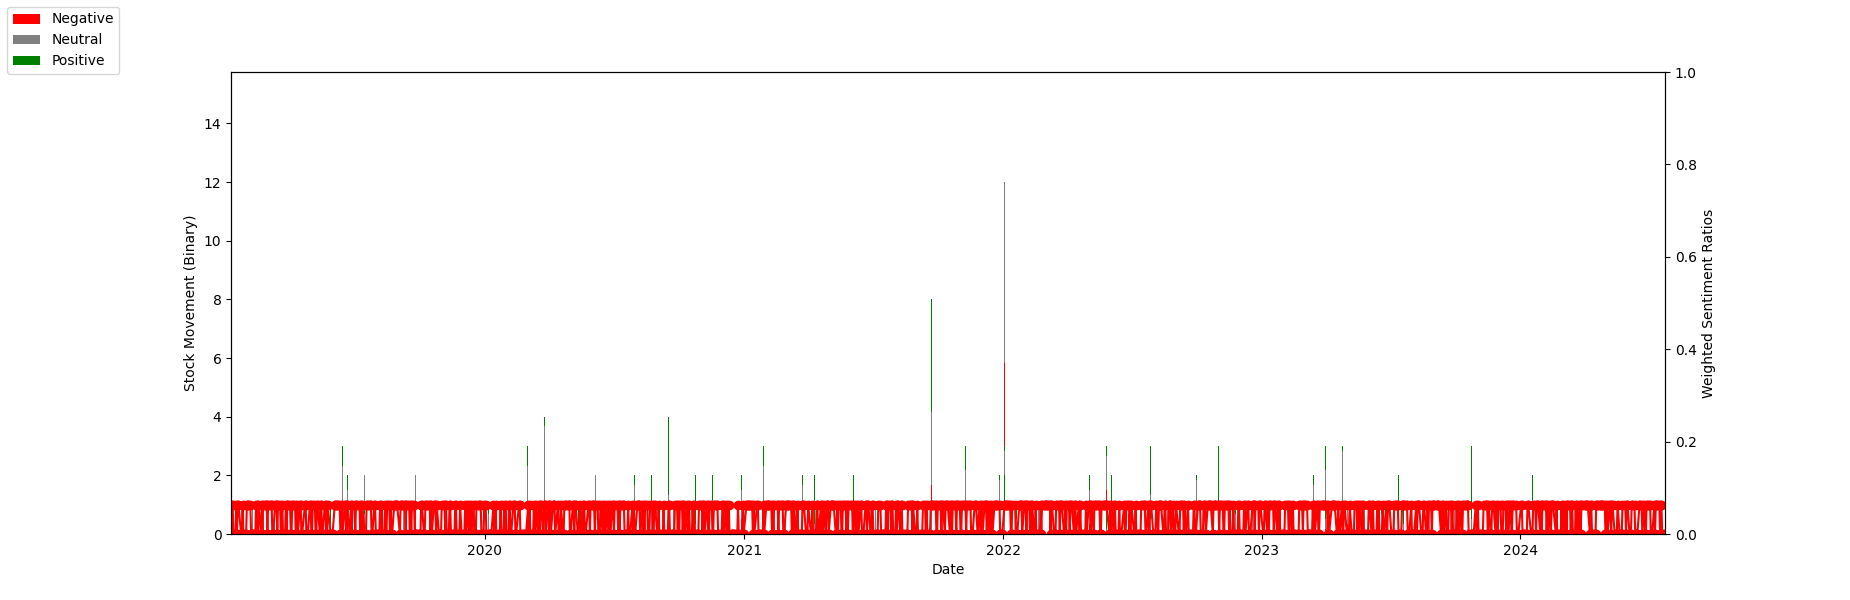

In [16]:
# Visualize Example Stock Price Movements (Up/Down) with Article Counts
%matplotlib ipympl
tz = pytz.timezone('America/New_York')

fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 6, forward=True)

tolerance = 2  # points

ret_binary = ret_df['CVX'].apply(lambda x: 1 if x > 0.0 else 0)

ax1.plot(ret_df.index, ret_binary, 'ro-', picker=tolerance)

# Calculate weighted values
dates = df_merged['Date']
weights = {
    "Negative": (df_merged['Neg_ratio_avg'] * df_merged['article_count']).tolist(),
    "Neutral": (df_merged['Neu_ratio_avg'] * df_merged['article_count']).tolist(),
    "Positive": (df_merged['Pos_ratio_avg'] * df_merged['article_count']).tolist()
}

colors = {
    "Negative": 'red',
    "Neutral": 'gray',
    "Positive": 'green'
}

ax2 = ax1.twinx()

width = 0.1
bottom = np.zeros(len(dates))

for sentiment, weight in weights.items():
    p = ax1.bar(dates, weight, width, label=sentiment, bottom=bottom, color=colors[sentiment])
    bottom += weight

ax1.set_xlim(left=ret_df.index.min(), right=ret_df.index.max())
ax2.set_xlim(left=ret_df.index.min(), right=ret_df.index.max())

# Add labels and legend
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Movement (Binary)')
ax2.set_ylabel('Weighted Sentiment Ratios')
fig.legend(loc='upper left')

plt.show()




def onclick(event):
    line = event.artist
    xdata, ydata = line.get_data()
    ind = event.ind
    datetime_obj  = xdata[ind][0].astype('datetime64[s]').astype(datetime)
    formatted_date = datetime_obj.strftime('%Y-%m-%d')
    print(formatted_date)
    #query = 'summarize the top news articles for chevron?'
    #top_results = 3
    #print(textwrap.fill(ask_vector_query(query, top_results, date=str(formatted_date), pinecone_index = "newsembedding3"), width=80))

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onclick)

In [17]:
# prep data for modeling
df_merged_drop = df_merged.drop(['Returns','Returns Next Day', 'Returns Next Day(no NaN)'], axis=1)
df_dropna = df_merged_drop.dropna()

# Convert the 'Date' column to datetime
df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])

# Define the split date
base_date = pd.to_datetime('2022-01-01')
split_date = pd.to_datetime('2024-01-01')

# Split the DataFrame
train_df = df_dropna[(df_dropna['Date'] < split_date) & (df_dropna['Date'] >= base_date)]
test_df = df_dropna[df_dropna['Date'] >= split_date]

# define input variables
X_train_df = train_df.drop(columns=['Date','Ticker','Returns (no NaN)'])
X_test_df = test_df.drop(columns=['Date','Ticker','Returns (no NaN)'])

# define target variable
y_train_df = train_df['Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)
y_test_df = test_df['Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)

# Split the dataset into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# If you need to separate features and labels
X_train = X_train_df
y_train = y_train_df

X_test = X_test_df
y_test = y_test_df

print(len(X_train), len(y_train), len(X_test), len(y_test))

893 893 87 87


<ipython-input-17-36853a949fb5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])


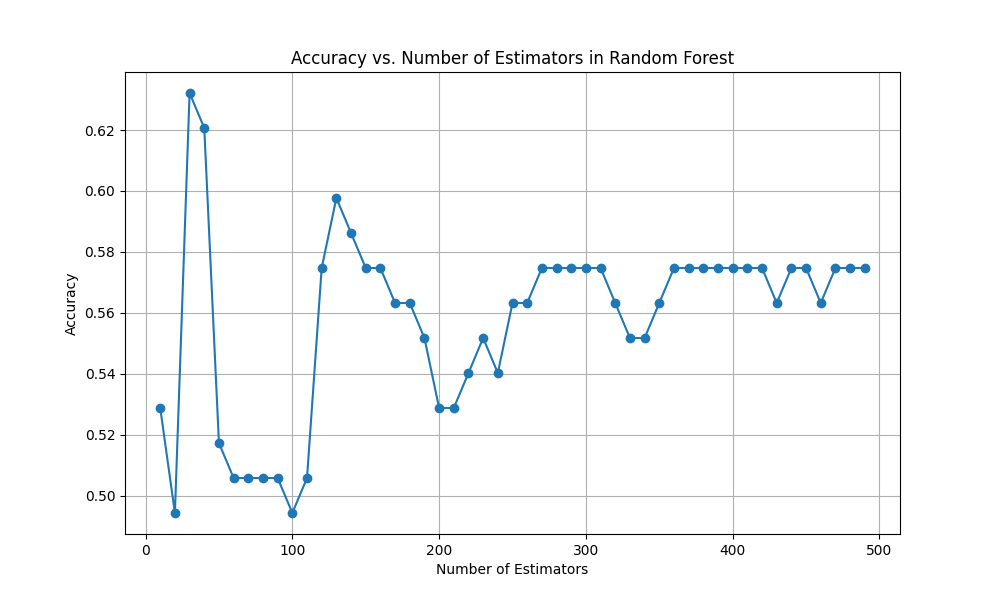

Best Number of Estimators: 30
Best Accuracy Score: 0.632183908045977
Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.72      0.58      0.64        50
           1       0.55      0.70      0.62        37

    accuracy                           0.63        87
   macro avg       0.64      0.64      0.63        87
weighted avg       0.65      0.63      0.63        87



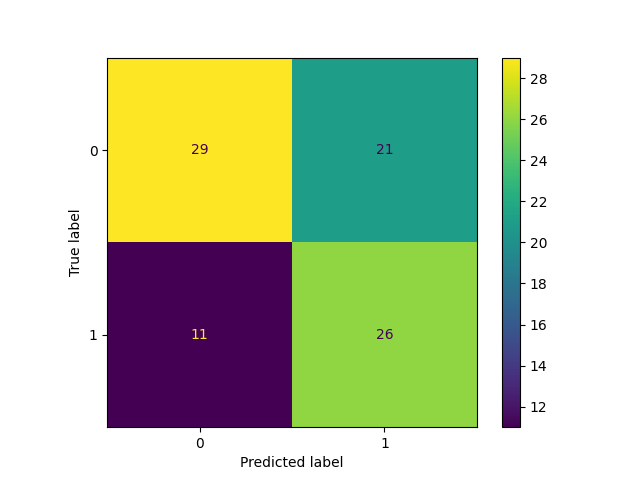

In [18]:
# Plot vs n_estimators
n_estimators_range = range(10, 500, 10)
accuracy_scores = []

# Loop over the n_estimators_range
for n in n_estimators_range:
    rf_clf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracy_scores, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Estimators in Random Forest')
plt.grid(True)
plt.show()

# Find the best n_estimators
best_n = n_estimators_range[np.argmax(accuracy_scores)]
best_score = max(accuracy_scores)

# Train the final model with the best n_estimators
best_rf_clf = RandomForestClassifier(n_estimators=best_n, random_state=42)
best_rf_clf.fit(X_train, y_train)
y_pred_best = best_rf_clf.predict(X_test)

# Print the classification report and display the confusion matrix
print(f"Best Number of Estimators: {best_n}")
print(f"Best Accuracy Score: {best_score}")
print("Classification Report for the Best Model:")
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(best_rf_clf, X_test, y_test)
plt.show()

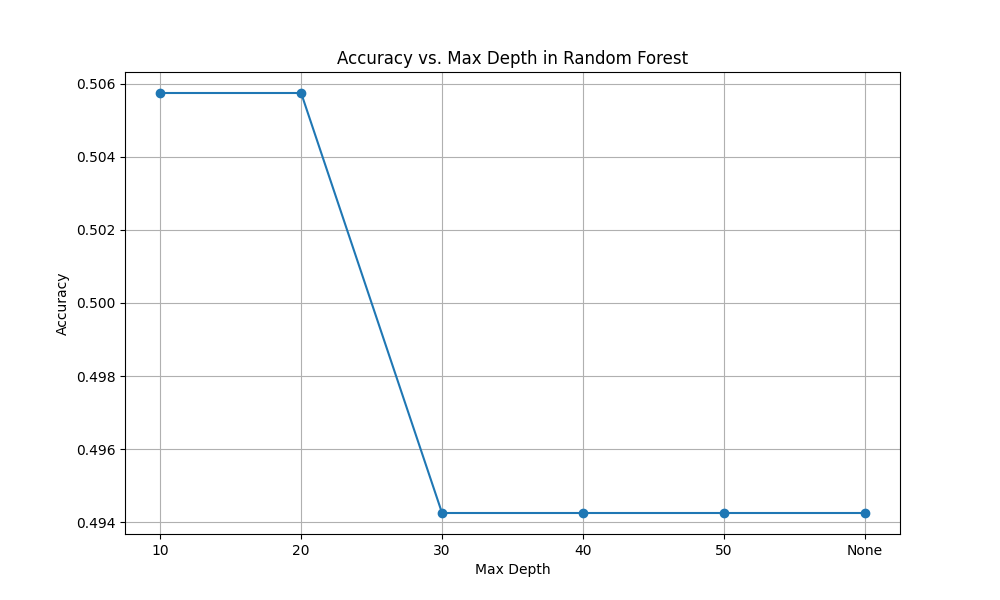

Best Max Depth: 10
Best Accuracy Score: 0.5057471264367817
Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.65      0.30      0.41        50
           1       0.45      0.78      0.57        37

    accuracy                           0.51        87
   macro avg       0.55      0.54      0.49        87
weighted avg       0.57      0.51      0.48        87



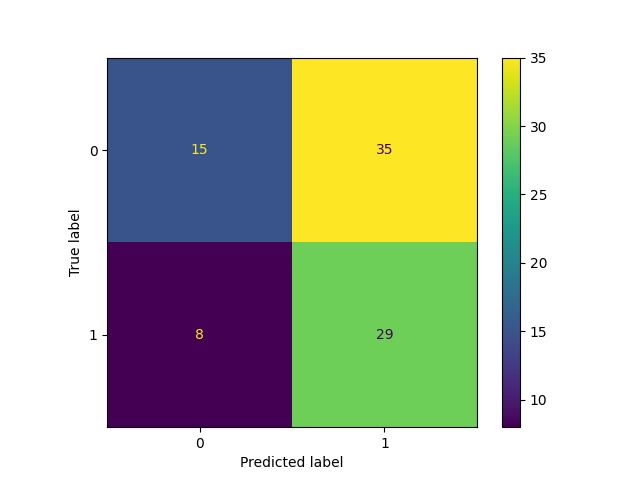

In [19]:
# Plot vs tree depth
max_depth_range = [10, 20, 30, 40, 50, None]
accuracy_scores = []

# Loop over the max_depth_range
for depth in max_depth_range:
    rf_clf = RandomForestClassifier(max_depth=depth, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot([str(depth) for depth in max_depth_range], accuracy_scores, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Max Depth in Random Forest')
plt.grid(True)
plt.show()

# Find the best max_depth
best_depth = max_depth_range[np.argmax(accuracy_scores)]
best_score = max(accuracy_scores)

# Train the final model with the best max_depth
best_rf_clf = RandomForestClassifier(max_depth=best_depth, random_state=42)
best_rf_clf.fit(X_train, y_train)
y_pred_best = best_rf_clf.predict(X_test)

# Print the classification report and display the confusion matrix
print(f"Best Max Depth: {best_depth}")
print(f"Best Accuracy Score: {best_score}")
print("Classification Report for the Best Model:")
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(best_rf_clf, X_test, y_test)

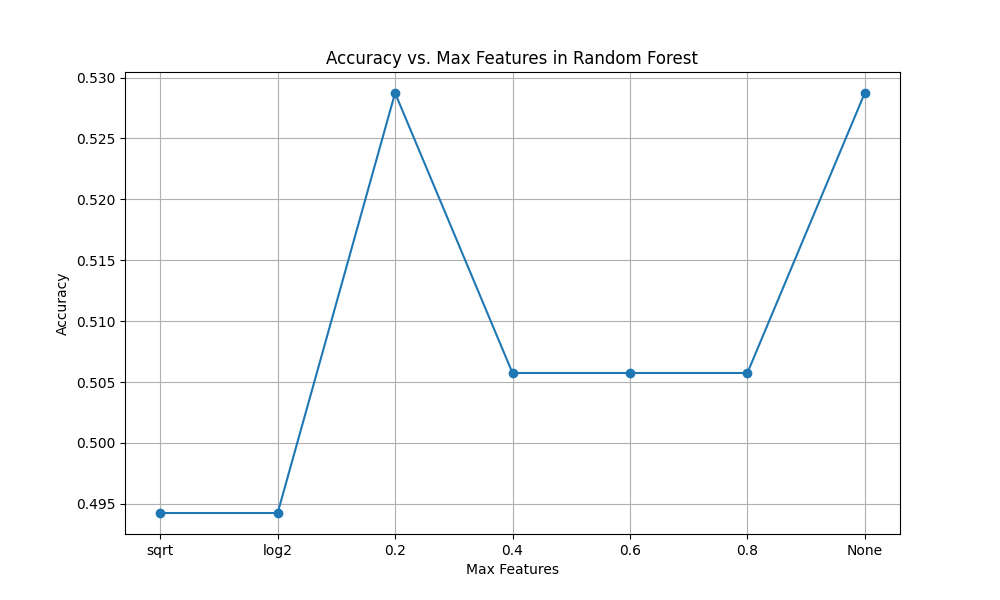

Best Max Features: 0.2
Best Accuracy Score: 0.5287356321839081
Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.66      0.38      0.48        50
           1       0.47      0.73      0.57        37

    accuracy                           0.53        87
   macro avg       0.56      0.55      0.52        87
weighted avg       0.57      0.53      0.52        87



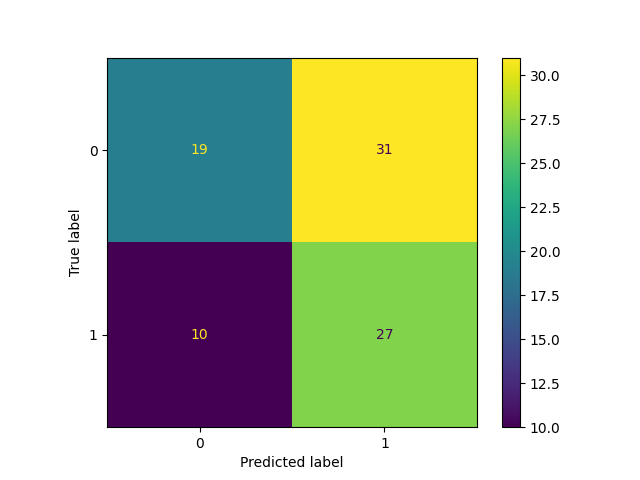

In [20]:
# Plot vs max features
max_features_range = ['sqrt', 'log2', 0.2, 0.4, 0.6, 0.8, None]
accuracy_scores = []

# Loop over the max_features_range
for feature in max_features_range:
    rf_clf = RandomForestClassifier( max_features=feature, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot([str(feature) for feature in max_features_range], accuracy_scores, marker='o')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Max Features in Random Forest')
plt.grid(True)
plt.show()

# Find the best max_features
best_feature = max_features_range[np.argmax(accuracy_scores)]
best_score = max(accuracy_scores)

# Train the final model with the best max_features
best_rf_clf = RandomForestClassifier(max_features=best_feature, random_state=42)
best_rf_clf.fit(X_train, y_train)
y_pred_best = best_rf_clf.predict(X_test)

# Print the classification report and display the confusion matrix
print(f"Best Max Features: {best_feature}")
print(f"Best Accuracy Score: {best_score}")
print("Classification Report for the Best Model:")
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(best_rf_clf, X_test, y_test)
plt.show()

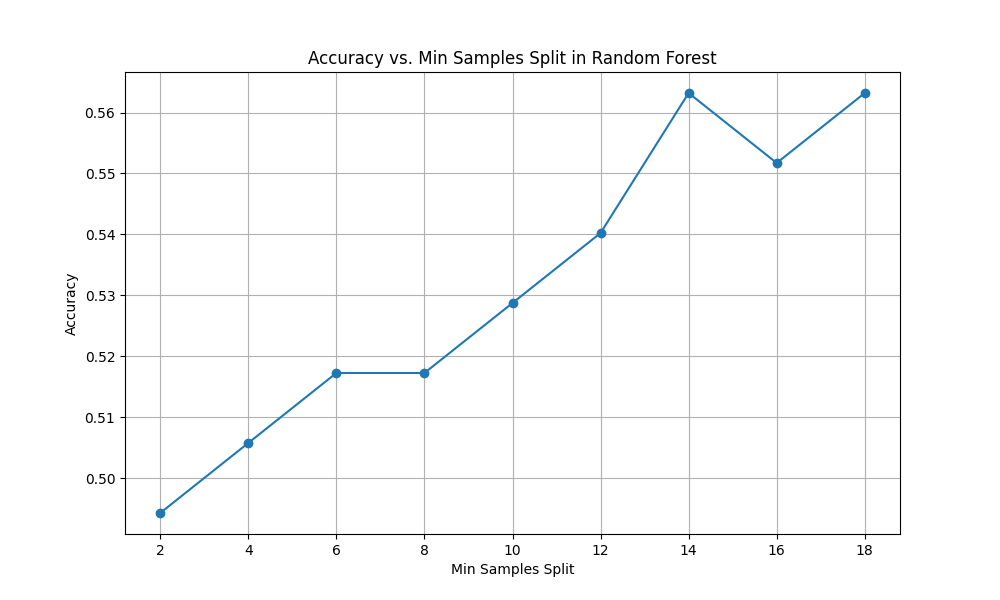

Best Min Samples Split: 14
Best Accuracy Score: 0.5632183908045977
Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.70      0.42      0.53        50
           1       0.49      0.76      0.60        37

    accuracy                           0.56        87
   macro avg       0.60      0.59      0.56        87
weighted avg       0.61      0.56      0.56        87



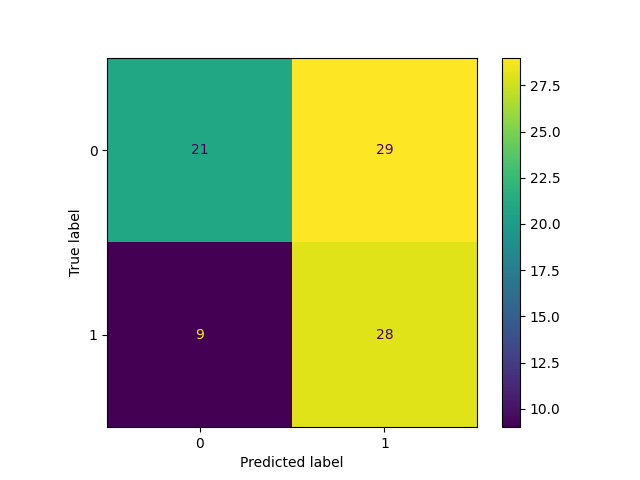

In [21]:
# Plot vs min_samples_split
min_samples_split_range = range(2, 20, 2)
accuracy_scores = []

# Loop over the min_samples_split_range
for split in min_samples_split_range:
    rf_clf = RandomForestClassifier(min_samples_split=split, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_range, accuracy_scores, marker='o')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Min Samples Split in Random Forest')
plt.grid(True)
plt.show()

# Find the best min_samples_split
best_split = min_samples_split_range[np.argmax(accuracy_scores)]
best_score = max(accuracy_scores)

# Train the final model with the best min_samples_split
best_rf_clf = RandomForestClassifier(min_samples_split=best_split, random_state=42)
best_rf_clf.fit(X_train, y_train)
y_pred_best = best_rf_clf.predict(X_test)

# Print the classification report and display the confusion matrix
print(f"Best Min Samples Split: {best_split}")
print(f"Best Accuracy Score: {best_score}")
print("Classification Report for the Best Model:")
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(best_rf_clf, X_test, y_test)
plt.show()

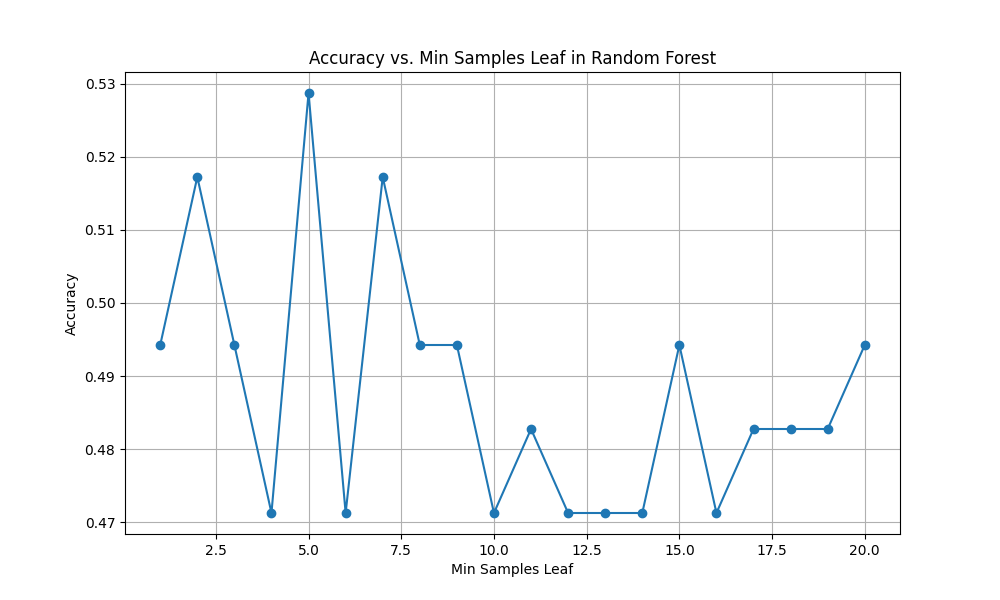

Best Min Samples Leaf: 5
Best Accuracy Score: 0.5287356321839081
Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.71      0.30      0.42        50
           1       0.47      0.84      0.60        37

    accuracy                           0.53        87
   macro avg       0.59      0.57      0.51        87
weighted avg       0.61      0.53      0.50        87



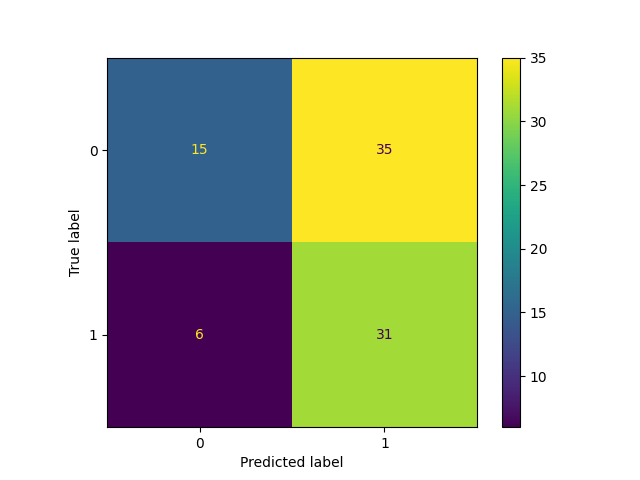

In [22]:
# Plot vs min_samples_leaf
min_samples_leaf_range = range(1, 21)
accuracy_scores = []

# Loop over the min_samples_leaf_range
for leaf in min_samples_leaf_range:
    rf_clf = RandomForestClassifier(min_samples_leaf=leaf, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_range, accuracy_scores, marker='o')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Min Samples Leaf in Random Forest')
plt.grid(True)
plt.show()

# Find the best min_samples_leaf
best_leaf = min_samples_leaf_range[np.argmax(accuracy_scores)]
best_score = max(accuracy_scores)

# Train the final model with the best min_samples_leaf
best_rf_clf = RandomForestClassifier(min_samples_leaf=best_leaf, random_state=42)
best_rf_clf.fit(X_train, y_train)
y_pred_best = best_rf_clf.predict(X_test)

# Print the classification report and display the confusion matrix
print(f"Best Min Samples Leaf: {best_leaf}")
print(f"Best Accuracy Score: {best_score}")
print("Classification Report for the Best Model:")
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(best_rf_clf, X_test, y_test)
plt.show()

In [26]:
######## Train Random Forest Model with Best Parameters ############

# Define the parameter grid
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'bootstrap': [True, False]
#}
param_grid = {
    'n_estimators': [10,50,100,500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [1,2,5,10],
    'min_samples_leaf': [1,2,5,10],
    'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.6, 0.8],
    'bootstrap': [True,False]
}

# Create a Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Train the classifier on the training set
grid_search.fit(X_train, y_train)

# Output the best parameters
print(grid_search.best_params_)

# Use the best estimator for predictions
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(X_train_df.columns)
print(best_model.feature_importances_)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


KeyboardInterrupt: 

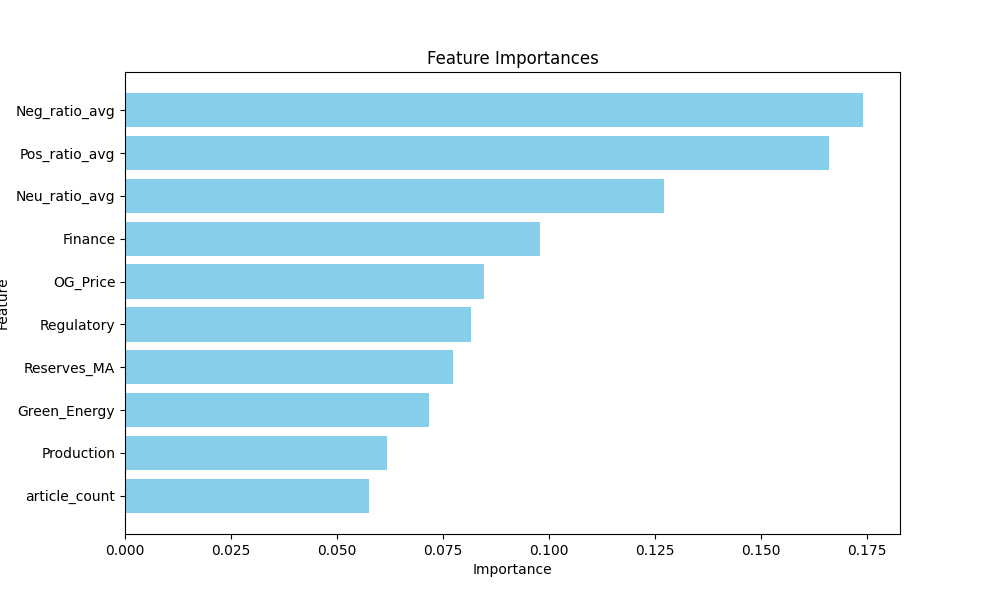

In [24]:
# Extract feature importances from the model
importances = best_model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()